
# ACS Occupation Autocoder Workflow

*The U.S. Census Bureau reviewed this data product for unauthorized disclosure of confidential information and approved the disclosure avoidance practices applied to this release. CBDRB-FY21-POP001-0171.*

## Introduction

The American Community Survey (ACS) asks employed respondents to report about their occupation and typical activities on the job in open-ended text fields. Traditionally, clerical coders at the Census National Processing Center manually assign Census occupation codes to write-in entries. In 2012, Census implemented a logistic regression autocoder in an attempt to reduce the number of cases sent to clerical coding. This jupyter notebook presents a complete machine learning (ML) workflow to develop an autocoder to assign Census occupation codes to occupation write-in data from the 2018 and 2019 ACS. 

This project seeks to evaulate the autocoder and find areas where it can be improved. My evaluation strategy was to develop a competing autocoder using updated ML tools to determine if it could result in fewer cases going to clerical coding while maintaining a consistent level of (and ideally improving) prediction accuracy. As you will see below, I leverage existing linkage data with a random forest classifier to implement a custom "ensemble" that improves model accuracy over the existing autocoder. For example, at one threshold of model accuracy, the current production autocoder (2012 vintage) saves about 50 percent of records from going to clerical coding, while my ensemble saves about 86 percent.

In order to use ML methods for the write-in data, I use natural language processing (NLP) technique to convert write-in text into a numeric form. No pre-processing is done to the text; instead, I rely on a pipeline that would conceivably have enough support to detect a signal from the write-ins while allowing for common spelling errors to have weight in generating predictions (with more time, however, exploring alternatives would have been useful). Even with the subsample used here (more on this below) and using lemmatized text to reduce the horizontal dimension of input matrices, model features exceeded 100,000. For the freamework chosen, this sample size (roughly a 3 percent subsample of all data available), easily runs into memory limitations on the existing computing infrastructure.

The ML model used here was estimated in a separate routine, chosen by Grid Search, and then "pickled" for use here. Code generating the Grid Search is available by request. However, that code is farily generic. The majority of processing work involves data preparation and feature engineering, which is demonstrated in this notebook.

The workflow consists of loading write-in data, conducting feature engineering, and applying a custom ML "ensemble" consisting of an "index autocoder" (see the `exact_match_results.ipynb` notebook in this repository) and a Random Forest Classifier. I then evaluate the model accuracy and record indicators of which records were assigned matches at a given stage. I also present a simple heuristic that will help stakeholders and other decision makers choose a simple accuracy threshold that can determine the expected cost savings associated with different modeling options. For example, I calculate the number of records that must go to clerical coding for a given model accuracy; that tradeoff can be chosen by choosing a predicted probability threshold. If estimates of the per-unit cost (in dollars and/or time) is known *ex ante*, this heuristic could provide a direct cost savings estimate for different modeling options.

Finally, Census occupation codes for these files are based on the 2018 [Standard Occupational Classification (SOC) System](https://www.bls.gov/soc/)). See my other [repository](https://github.com/krwilkin/census-occ-to-soc) for a more detailed discussion of the relationship between the SOC and Census occupation codes.

In [1]:
# import modules
import pandas as pd
import numpy as np
import json
import os
import joblib
import re

In [2]:
os.getcwd()

'/projects/users/wilki341'

In [45]:
# import data
occdf = pd.read_json('occ_index_clean.json')
acs = pd.read_csv('acs_occ_sample_n250.csv')

/apps/anaconda/envs/datascience/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (64,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
occdf.head()

,title,cenocc,edrestr,indrestr
0,Admiral,10,None,None
1,Board chairman,10,None,None
2,Board member,10,None,None
3,Bureau chief,10,None,"[{'range': 'int({0}) in range(9370,9590+1)', '..."
4,CEO,10,None,None


In [5]:
acs.head()

,CMID,PNUM,CTY,ST,GQ,IMO,MODE,UAGE,AGE,FAGE,...,inx4,ocw1,ocw2,tocoding,INX1,auto_uind,auto_uocc,GQMAJTYP,year,SEQ
0,587851296,1.0,31,17,0,12.0,6,57.0,57.0,0,...,4,PRESIDENT,PROVIDE MANAGEMENT ASSISTANCE TO SMALL BUSINES...,0,NaN,7390.0,10.0,NaN,2019,0.0
1,559844799,1.0,47,36,0,5.0,6,40.0,40.0,0,...,4,VICE PRESIDENT RESEARCH,EVALUATE SUCCESS OF STUDENTS AND PROGRAM FOR Y...,0,NaN,7860.0,10.0,NaN,2019,0.0
2,553756630,1.0,23,34,0,2.0,6,46.0,46.0,0,...,3,VP INFORMATION TECHNOLOGY,OVERSEE INFORMATION TECHNOLOGY DEPARTMENT,0,NaN,NaN,NaN,NaN,2019,0.0
3,579310994,1.0,17,25,0,10.0,1,63.0,63.0,0,...,4,INDEPENDENT CORPORATE DIRECTOR,BOARD OF DIRECTOR TO 1 PRIVATE 1 PUBLICALLY TR...,0,NaN,NaN,NaN,NaN,2019,0.0
4,537615239,1.0,11,9,0,8.0,6,59.0,59.0,0,...,4,PRESIDENT AND CEO,RUN THE COMPANY,0,NaN,NaN,NaN,NaN,2018,NaN


In [47]:
# convert occupation and industry codes to four-digit strings
# convert 'cenocc' to character and add leading zeroes
# (a) define function for adding leading zeroes to a 4-character string
def leadingzeroes( occ_code ):
    if len( occ_code ) == 4:
        return( occ_code )
    else:
        return( '{0}{1}'.format( '0' * ( 4 - len( occ_code ) ) , occ_code ) )

# (b) add leading zeroes to cenocc and print result
occdf['cenocc'] = occdf['cenocc'].apply(lambda x: leadingzeroes(str(int(x))))
occdf.head()

,title,cenocc,edrestr,indrestr
0,Admiral,0010,None,None
1,Board chairman,0010,None,None
2,Board member,0010,None,None
3,Bureau chief,0010,None,"[{'range': 'int({0}) in range(9370,9590+1)', '..."
4,CEO,0010,None,None


In [48]:
# (c) add leading zeroes to the OCC and IND fields in the acs sample
acs['OCC'] = acs['OCC'].apply(lambda x: leadingzeroes(str(int(x))))
acs['IND'] = acs['IND'].apply(lambda x: leadingzeroes(str(int(x))))

acs[['OCC','IND']].sample(n=50).head(20)

,OCC,IND
41866,2632,7370
68079,3940,7780
38578,2300,8470
110968,7140,3580
29927,1825,8080
97769,6040,0170
63990,3655,8191
131704,8910,3980
119194,7810,1180
36887,2100,7270


Next, we import the "pickled" best model from a random forest classification model. I did a systematic grid search evaluating models across two sets of paramters: `n_estimators` and `max_depth`. The parameter `n_estimators` is the number of individual decision trees that make up the forest, while `max_depth` is the maximum number of branches a tree will have. The following dictionary shows the combinations of parameters I tested for the grid search.

Even on this small sample, the random forest grid search across these parameters took considerable time (over 24 hours). In fact, at the time of this writing, a grid search across the same parameters but using the `GradienBoostingClassifier()` is still running after 125 hours of continuous operation. As such, I could not be exhaustive in testing many parameters and different methods due to the size of the data.

From the parameters used, the "best model" chosen by grid search was the one with 900 estimators and a max depth of 100.

In [7]:
parameters = {'n_estimators' : [20, 600, 900],
              'max_depth' : [5, 25, 50, 100]}

In [44]:
# import pickled results from random forest grid search
mdl = joblib.load('mdl_occ_best_rf_tfidf_lemma.pkl')

In [9]:
mdl.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 900,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## 1. Execute Index Autocoder
This section executes the occupation autocoder functions. Recall that job titles are matched to the occupation index. If a single occupation code can be assigned from the index, we record where the match was made and set aside the matched results in a separate dataframe object.

The index autocoder uses a series of user defined functions that are described in a previous notebook. Below we load them. The JSON file loaded earlier in this notebook contains the pre-processed occupation index. The only step remaining is to create the composite `ocw3` variable, which is a combined string of `ocw1` and `ocw2` separated by space, in the ACS sample. In addition, occupation index titles should be capitalized to match the format of ACS write-ins (alternatively the ACS write-ins could be converted to lowercase).

Recall that the index autocoder seprately merges the index on each of the occupation write-in fields, processes the results, and then merges the codes to the main analysis file. All of this is covered in detail in the index autocoder notebook.

### Create `ocw3`

In [49]:
# create ocw3
acs['ocw3'] = acs.ocw1 + ' ' + acs.ocw2

### Load Index Autocoder Functions

In [50]:
# load functions comprising the index autocoder

# define function to resolve education restrictions
# NOTES: resolves to (True, False, None). input parameters are:
#        edr = text string containing education reference in parseable code
#        ed  = value of years of schooling variable in ACS (e.g., SCHL)
def resolveed( edr , ed ):
    if edr is None:
        return None
    return eval( edr.format( ed ) )


# define function to resolve industry restrictions
# NOTES: resolves to (True, False). input paramters are:
#        indr = JSON object of industry/cow restrictions and exceptions
#        ind  = ACS variable for industry (e.g., IND); expecting a string
#        cow  = ACS variable for class of worker (e.g., COW)
def resolveind( indr , ind , cow ):
    if indr is None:
        return None
    else:
        # define a checks dictionary
        check_vals = { 'code' : ind ,
                       'range' : int(ind) ,
                       'cow' : cow }

        # initialize a results list
        ind_check = []

        # loop over elements of 'indr' (i.e., the json object)
        # NOTE: we exclude the 'text' key; this should be changed in production
        for i in indr:
            checks = [ x for x in i.keys() if i[x] is not None and x != 'text' ]

            # if 'text' is the only restriction, then consider False. if no restrictions, then True
            # NOTE: this is because we omit 'text'; treating it as 'False' here prevents a false positive
            #       though might induce a false negative. one method to incorporate the 'text' field is
            #       to add a parameter that takes the value of 'inw2' from the acs
            if len( checks ) == 0:
                if i['text'] is None:
                    ind_check.append( True )
                else:
                    ind_check.append( False )
            else:
                check_dict = {}

                for j in checks:
                    if j != 'exc':
                        check_dict[j] = eval( i[j].format( check_vals[j] ) )
                    else:
                        exc_keys = [ x for x in i[j].keys() if not i[j][x] is None and x != 'text' ]

                        if len( exc_keys ) == 0:
                            if i[j]['text'] is None:
                                check_dict[j] = True
                            else:
                                check_dict[j] = False
                        else:
                            exc_dict = {}
                            for k in exc_keys:
                                exc_dict[k] = eval( i[j][k].format( check_vals[k] ) )
                            if sum( exc_dict.values() ) == len( exc_keys ):
                                check_dict[j] = True
                            else:
                                check_dict[j] = False

                # return True only if all components are met, False otherwise
                if sum( check_dict.values() ) == len( checks ):
                    ind_check.append( True )
                else:
                    ind_check.append( False )

        # final industry restriction determination
        # NOTE: return True if any industry restriction is true, False otherwise
        if True in ind_check:
            return True
        else:
            return False


# define function to denote a valid match
def assignocc(edres = None, indres = None):
    if indres is None:
        if edres is None:
            return None
        else:
            if edres is True:
                return True
            else:
                return False
    elif indres is True:
        if edres is None:
            return True
        elif edres is True:
            return True
        else:
            return False
    else:
        return False


# define function to output index autocode
def indexautocode(occ1t, occ1n, occ2t, occ3t, occ3n, occ2n=None):
    occ_out = ''
    match_level = 0
    
    for i, j in zip([occ1t, occ1n, occ2t, occ2n, occ3t, occ3n],
                    [11, 10, 21, 20, 31, 30]):
        if not pd.isnull(i):
            occ_out = i
            match_level = j
            if len(occ_out.split()) == 1:
                break
    
    if match_level == 0:
        return {'indexocc' : None ,
                'match_code' : None }
    else:
        if len(occ_out.split()) > 1:
            match_level = match_level * 10 + 2
        else:
            match_level = match_level * 10 + 1
        return {'indexocc' : occ_out ,
                'match_code' : match_level}

### Merge Index with Occupation Write-Ins

In [51]:
# define set of keep variables from the acs
acs_keep = ['OCC','auto_uocc','ocw1','ocw2','IND','inw2','inw3','SCHL','COW']
occ_keep = ['title','cenocc','edrestr','indrestr','ind2017restr']

# set occ index titles to uppercase
occdf['title'] = occdf.title.apply(lambda x: x.upper())

# create a sequence variable identifying each record as unique
acs['recid']=np.arange(len(acs)).astype(str)


# merge
acs_keep.append('recid')

acsmrg1 = pd.merge(acs[acs_keep], 
                   occdf, 
                   left_on='ocw1', 
                   right_on='title')

acsmrg2 = pd.merge(acs[acs_keep], 
                   occdf, 
                   left_on='ocw2', 
                   right_on='title')

acs_keep3 = acs_keep.copy()
acs_keep3.append( 'ocw3' )

acsmrg3 = pd.merge(acs[acs_keep3 ], 
                   occdf, 
                   left_on='ocw3', 
                   right_on='title')

### Resolve and Education, Industry, or Class of Worker Resrictions

In [52]:
# resolve industry and education fields using the resolveed and resolveind functions
acsmrg1['resed'] = np.vectorize(resolveed)(acsmrg1['edrestr'], acsmrg1['SCHL'])

acsmrg2['resed'] = np.vectorize(resolveed)(acsmrg2['edrestr'], acsmrg2['SCHL'])

acsmrg3['resed'] = np.vectorize(resolveed)(acsmrg3['edrestr'], acsmrg3['SCHL'])

acsmrg1['resind'] = np.where(acsmrg1.indrestr.isnull() ,
                             None,
                             np.vectorize(resolveind)(acsmrg1['indrestr'], acsmrg1['IND'], acsmrg1['COW']))

acsmrg2['resind'] = np.where(acsmrg2.indrestr.isnull(),
                             None,
                             np.vectorize(resolveind)(acsmrg2['indrestr'], acsmrg2['IND'], acsmrg2['COW']))

acsmrg3['resind'] = np.where(acsmrg3.indrestr.isnull(),
                             None,
                             np.vectorize(resolveind)(acsmrg3['indrestr'], acsmrg3['IND'], acsmrg3['COW']))

### Assign Index Autocode

In [53]:
# determine whether a matching index entry can be assigned to a write-in
acsmrg1['assignocc'] = np.where(acsmrg1.resed.isnull() & acsmrg1.resind.isnull(),
                                None,
                                np.vectorize(assignocc)(acsmrg1['resed'], acsmrg1['resind']))

acsmrg2['assignocc'] = np.where(acsmrg2.resed.isnull() & acsmrg2.resind.isnull(),
                                None,
                                np.vectorize(assignocc)(acsmrg2['resed'], acsmrg2['resind']))

acsmrg3['assignocc'] = np.where(acsmrg3.resed.isnull() & acsmrg3.resind.isnull(),
                                None,
                                np.vectorize(assignocc)(acsmrg3['resed'], acsmrg3['resind']))

### Collapse Autocode Results to Single Record and Join with ACS File

In [54]:
# collapse cenocc into space-delmited string for cases where assignocc = True
acstrue1 = acsmrg1[acsmrg1.assignocc==True][['recid','cenocc']].astype(str).groupby('recid').agg(lambda x: ' '.join( x.unique())).copy().reset_index()
acstrue2 = acsmrg2[acsmrg2.assignocc==True][['recid','cenocc']].astype(str).groupby('recid').agg(lambda x: ' '.join( x.unique())).copy().reset_index()
acstrue3 = acsmrg3[acsmrg3.assignocc==True][['recid','cenocc']].astype(str).groupby('recid').agg(lambda x: ' '.join( x.unique())).copy().reset_index()

In [55]:
# collapse cenocc into space-delmited string for cases where assignocc = None
acsnone1 = acsmrg1[acsmrg1['assignocc'].isnull()][['recid','cenocc']].astype(str).groupby('recid').agg(lambda x: ' '.join( x.unique())).copy().reset_index()
acsnone2 = acsmrg2[acsmrg2['assignocc'].isnull()][['recid','cenocc']].astype(str).groupby('recid').agg(lambda x: ' '.join( x.unique())).copy().reset_index()
acsnone3 = acsmrg3[acsmrg3['assignocc'].isnull()][['recid','cenocc']].astype(str).groupby('recid').agg(lambda x: ' '.join( x.unique())).copy().reset_index()

In [56]:
# rename 'cenocc' column in each data frame
# NOTE: each table has the same name for column 'cenocc'; we want the code to be table-specific
for i in range(1, 4):
    for j in ['true', 'none']:
        tabname = 'acs{0}{1}'.format(j, i)
        occname = 'occ{0}{1}'.format(i, j)
        globals()[tabname].rename(columns={'cenocc' : occname}, inplace=True)

In [57]:
# get list of tables to merge with ACS
# NOTE: only merge tables where matches were found
dat_list = ['acs']

for i in range(1, 4):
    for j in ['true', 'none']:
        tabname = 'acs{0}{1}'.format(j, i)
        if len( globals()[tabname] ) > 0:
            dat_list.append( tabname )

dat_list

['acs', 'acstrue1', 'acsnone1', 'acstrue2', 'acsnone2', 'acstrue3', 'acsnone3']

In [58]:
# merge tables together
from functools import reduce

acs_mrg = reduce( lambda left, right: pd.merge(left, right, on=['recid'], how='outer'),
                                               [globals()[x] for x in dat_list] )

In [59]:
# check the shape of the resulting merge file
print( 'original acs file has same number of records as the merged file:', len(acs) == len(acs_mrg) )
print( 'shape of resulting merge file:' , acs_mrg.shape )

original acs file has same number of records as the merged file: True
shape of resulting merge file: (142500, 85)


### Make Final Index Autocode Assignment

In [60]:
# run index autocoder selection on the acs data
acs_mrg['indexocc']=np.vectorize(indexautocode)(acs_mrg.occ1true,
                                                acs_mrg.occ1none,
                                                acs_mrg.occ2true,
                                                acs_mrg.occ3true,
                                                acs_mrg.occ3none)

In [61]:
# extract results of index autocoder to separate variables (i.e., autocode and match code)
acs_mrg['indexautoocc'] = acs_mrg['indexocc'].apply(lambda x: x['indexocc'])
acs_mrg['indexautomcode'] = acs_mrg['indexocc'].apply(lambda x: x['match_code'])

### Examine the Distribution of Index Autocode Results

In [62]:
# distribution of match types
match_codes = pd.DataFrame(acs_mrg.indexautomcode.value_counts()).reset_index()
match_codes.columns = ['Match Code', 'Frequency']
match_codes['Match Code'] = match_codes['Match Code'].apply(lambda x: int(x))
match_codes['match_type'] = np.where(match_codes['Match Code'].apply(lambda x: str(x)[-1]) == '2',
                                     'list',
                                     'unique')
match_codes['match_source'] = match_codes['Match Code'].apply(lambda x: 'ocw{}'.format(str(x)[0]))
match_codes

,Match Code,Frequency,match_type,match_source
0,101,22638,unique,ocw1
1,111,14597,unique,ocw1
2,112,5078,list,ocw1
3,211,2926,unique,ocw2
4,212,1001,list,ocw2
5,102,67,list,ocw1
6,301,53,unique,ocw3
7,311,24,unique,ocw3
8,312,16,list,ocw3


### Get Index Autocode Match Rate
We get the set of unique occupation code matches from the index autocoder.

In [64]:
# overall match rate for unique matches across all sources
print('index autocoder occupation assignment rate:',
      '{:.1%}'.format(float(match_codes[(match_codes.match_type == 'unique')]['Frequency'].sum() / len( acs_mrg ))))

index autocoder occupation assignment rate: 28.2%


### Subset ACS File by Index Autocode Match

In [65]:
# set of acs write-ins with a unique index autocode
acs_auto_index = acs_mrg[acs_mrg.indexautomcode.apply(lambda x: x in [101,111,211,301,311])==True].copy()

In [66]:
# set of acs unmatched write-ins
acs_unmatch = acs_mrg[acs_mrg.indexautomcode.apply(lambda x: x in [101,111,211,301,311])==False]['recid'].copy()

In [67]:
# verify that the total number of records in each file matches that of the full file
len(acs_auto_index) + len(acs_unmatch) == len(acs)

True

## 2. Random Forest Occupation Autocoder
In the previous section we saw that about 28 percent of write-ins for our sample data were matched to a unique Census occupation code. In this section, we apply our best random forest model to predict occupation codes from the remaining unmatched set of occupation write-ins.

We must first prepare the ACS write-in data so that it comprises the same fields used by the random forest estimator. These fields include all engineered features as well as the vectorized text features used by the `nltk` algorithms. Because the vectorization was done on the full sample, we must first vectorize the complete file then isolate the set of unmatched records to be processed through the model. Vectorization for this model was done on lemmatized text. I present a user-defind function `cleantext()` that lemmatizes the occupation write-ins (note that we use `ocw3` as the text field). In order to use the built-in TF-IDF vectorizer on lemmatized text, it is necessary to define a "dummy" function.

### Import Libraries

In [68]:
from matplotlib import pyplot
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

import string
import nltk

stopwords = nltk.corpus.stopwords.words( 'english' )
wn = nltk.WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer

### Import MSA Population
The only external source of data used for feature engineering is Metropolitan Statistical Area (MSA) population estimates taken from the [U.S. Census Bureau](https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html). It is well known from the urban economics literature that specialized occupations are more likely to be found in larger urban areas. The MSA is a useful (though imperfect) proxy for a city. MSAs are comprised of one or more counties where one county represents the urban "core" with a population of 50,000 or more residents and any other counties are included if they are adjacent to MSA counties and meet certain thresholds of daily commuting to the urban core. I match MSA code based on a crosswalk between state and county FIPS codes in the ACS. MSA population is calculated as the sum of population for each county in the MSA. Population estimates are taken from public-use data published on the Census Web site.

In [69]:
# import msa population file
msadf = pd.read_json( 'msapop.json' )

'''
# for fun, plot distribution of city sizes in 2019
pyplot.hist(msadf[msadf.year==2019][['popest']])
pyplot.title('MSA population distribution, 2019')
pyplot.show()
'''

# drop cbsa_title
msadf.drop(columns='cbsa_title', inplace=True, axis=1)

# merge msa indicators and population estimates to acsonet
acsdat = pd.merge( acs ,
                   msadf ,
                   how = 'left' ,
                   left_on = ['ST', 'CTY', 'year'] ,
                   right_on = ['stfips', 'ctyfips', 'year'] )

# drop stfips and ctyfips from file
acsdat.drop(columns=['stfips','ctyfips'], axis=1, inplace=True)

### Feature Engineering
In this section I develop additional features to add to the model. The chosen set of features are based on a my experience working with individual labor market data and capture relevant characteristics that might predict differences in occupation. In addition, I add features related to the interview, such as interview mode, that might predict the quality of certain write-ins (e.g., spelling). Research also shows that respondents tend to not report earnings at higher rates than other survey content and that earnings "non-response" tends to be highest in the tails of the earnings distribution. If some occupations systematically occupy areas of the earnings distribution then earnings levels and the incidence of earnings non-response might be predictive of occupation. 

Other features include binary indicators of education level, age (scaled to be between zero and one), and a binary indicator for female. To deal with large continuous figures, such as MSA population size and earnings, I break each measure into a series of mutually exclusive categorical variables and then define separate binary indicators for each. I use a custom approach for doing so (instead of, say, `OneHotEncoding`), so that I can control the names of the features created, which aids in selecting a parsimonious data set for analysis. MSA population categories are standard as used by the Current Population Survey. I break the earnings distribution (both `UWAG` and `USEM`) into quantiles and then generate dummies for each quantile. Note that I used unedited earnings because many of the features that I use here are likely inputs for Census imputation methods and I prefer to avoid over-using correlated features. Using unedited earnings also allows for identifying a simple "missing earnings" indicator.

Conversations with IOSB staff indicated that many write-ins are in Spanish and that these may be disproportionately from respondents in Puerto Rico. To control for this, I use a binary indicator for Peurto Rico. However, MSAs definitions are restricted to the 50 United States and the District of Columbia.

In [70]:
# create urban indicator (urban is "has MSA")
acsdat['urban'] = np.where(acsdat['cbsa'].isnull() , 0 , 1 )

# create msa size categorical variable
# NOTE: non-urban records will be NaN
msasz_bins = [0, 99999, 249999, 499999, 999999,
              2499999, 4999999, msadf.popest.max()]

msasz_categ = pd.cut(acsdat['popest'],
                     bins = msasz_bins ,
                     labels = range(1,len(msasz_bins)))

acsdat.insert(acsdat.shape[-1], 'msasize', msasz_categ)

# set NaN msasize to zero (these are non-urban cases)
acsdat['msasize'] = np.where( acsdat['msasize'].isnull() , 0 ,
                              acsdat['msasize'] )

# create dummy for puerto rico
# NOTE: we don't use pr msas and pr is a bit unique (e.g., spanish write-ins)
acsdat['pr'] = np.where( acsdat.ST == 72 , 1 , 0 )

In [71]:
# missing earnings
# NOTE: missing if UWAG.isnull() and USEM.isnull()
acsdat['missearn'] = np.where( acsdat.USEM.isnull() & acsdat.UWAG.isnull() ,
                               1 , 0 )

# due to missing earnings, use indicators for percentile in distribution
# NOTES: paramters: 
#        tabname = dataframe object name (as string), 
#        variable = variable to summarize (as string),
#        quantiles = list of quantiles;
#
#        returns a list of values corresponding to the pth percentile.
#        requies the numpy and pandas packages. returns values for non-missing
#        (i.e., isnull() == False) records 
def getquantiles( tabname , variable , quantiles ):
    if isinstance(quantiles,(list)):
        quant_values = [np.percentile(globals()[tabname][globals()[tabname][variable].isnull() == False][[variable]], x) for x in quantiles]
        return quant_values
    else:
        raise ValueError( 'parameter quantiles must be a list' )

dec_labels = [5]
dec_labels += [x for x in range(10,100,10)]
dec_labels += [95, 99]

dec_values = getquantiles( 'acsdat' , 'UWAG' , dec_labels )

dec_labels += [100]
dec_values += [acsdat['UWAG'].max()]

dec_categ = pd.cut(acsdat['UWAG'],
                   bins = [0] + dec_values ,
                   labels = dec_labels )

dec_categ = dec_categ.cat.add_categories(0).fillna(0)

acsdat.insert(acsdat.shape[-1], 'uwagquantile', dec_categ)


# female binary indicator
acsdat['female'] = np.where( acsdat.AGE == 2, 1, 0)


# education categorical variable
ed_bins = [0, 15, 17, 19, 20, 21, 22, 23, 24]
ed_labels = ['lesshs', 'hsged', 'somecol', 'col2y', 
             'col4y', 'mast', 'prof', 'doct' ]

ed_categ = pd.cut(acsdat['SCHL'],
                  bins = ed_bins ,
                  labels = ed_labels )

acsdat.insert(acsdat.shape[-1], 'edcat', ed_categ)


# indicators for self-employment earnings
# has non-missing USEM
acsdat['hassem'] = np.where( acsdat['USEM'].isnull() , 0 , 1 )

'''
# explore the distribution of USEM
acsdat[acsdat.hassem==1][['USEM']].describe()

pyplot.hist(acsdat[(acsdat.hassem==1) & (acsdat.USEM > 0) & (acsdat.USEM <100000)][['USEM']])
pyplot.title('USEM distribution')
pyplot.show()
'''

# break up USEM into quantiles and create categorical variable
# define a function to return percentiles from a list of integers
decsem_labels = [x for x in range(10, 100, 10)]

decsem_values = getquantiles( 'acsdat' , 'USEM' , decsem_labels )

decsem_labels += [100]
decsem_values += [acsdat['USEM'].max()]

decsem_categ = pd.cut(acsdat['USEM'],
                      bins = [acsdat['USEM'].min()] + decsem_values ,
                      labels = decsem_labels )

decsem_categ = decsem_categ.cat.add_categories(0).fillna(0)

acsdat.insert(acsdat.shape[-1], 'usemquantile', decsem_categ)


# (k) normalized age variable
# NOTE: use MinMaxScaler to normalize
min_max_scaler = preprocessing.MinMaxScaler()

acsdat['minmaxage'] = min_max_scaler.fit_transform(acsdat[['AGE']])

'''
pyplot.hist(acsdat['minmaxage'])
pyplot.title('AGE distribution (MinMaxScaler())')
pyplot.show()
'''

# (l) convert categorical variables to dummies
# store list of feature columns names to be used later
feature_list = ['pr', 'female', 'missearn', 'urban', 'hassem', 'minmaxage']

# (l1) class of worker
cow_vals = pd.DataFrame(acsdat.COW.unique().tolist(), columns = ['COW'])
cow_vals.sort_values(axis=0, by='COW', inplace=True )
cow_vals.reset_index(inplace=True, drop=True)

cow_dum = pd.get_dummies(cow_vals, prefix=['cow'], columns=['COW'])

cow_vals = cow_vals.join(cow_dum)

feature_list += list( cow_dum.columns )

acsdat = acsdat.merge(cow_vals, how='left', on='COW')

# interview mode
mode_vals = pd.DataFrame(acsdat.MODE.unique().tolist(), columns = ['MODE'])
mode_vals.sort_values(axis=0, by='MODE', inplace=True )
mode_vals.reset_index(inplace=True, drop=True)

mode_dum = pd.get_dummies(mode_vals, prefix=['mode'], columns=['MODE'])

feature_list += list( mode_dum.columns )

mode_vals = mode_vals.join(mode_dum)

acsdat = acsdat.merge(mode_vals, how='left', on='MODE')

# (l3) msasize
msasz_vals = pd.DataFrame(acsdat.msasize.unique().tolist(), columns = ['msasize'])
msasz_vals.sort_values(axis=0, by='msasize', inplace=True )
msasz_vals.reset_index(inplace=True, drop=True)

msasz_vals['msasize'] = msasz_vals['msasize'].apply(lambda x: int(x))

msasz_dum = pd.get_dummies(msasz_vals, prefix=['msasz'], columns=['msasize'])

msasz_vals = msasz_vals.join(msasz_dum)
msasz_vals.drop(columns='msasz_0', inplace=True, axis=1)

feature_list += list( msasz_dum.columns )[1:]

acsdat = acsdat.merge(msasz_vals, how='left', on='msasize')


# (l4) education categories
ed_vals = pd.DataFrame(acsdat.edcat.unique().tolist(), columns = ['edcat'])
ed_vals.sort_values(axis=0, by='edcat', inplace=True )
ed_vals.reset_index(inplace=True, drop=True)

ed_dum = pd.get_dummies(ed_vals, prefix=['ed'], columns=['edcat'])

ed_vals = ed_vals.join(ed_dum)

feature_list += list( ed_dum.columns )

acsdat = acsdat.merge(ed_vals, how='left', on='edcat')


# wage quantiles
wag_vals = pd.DataFrame(acsdat.uwagquantile.unique().tolist(), columns = ['uwagquantile'])
wag_vals.sort_values(axis=0, by='uwagquantile', inplace=True )
wag_vals.reset_index(inplace=True, drop=True)

wag_dum = pd.get_dummies(wag_vals, prefix=['uwagq'], columns=['uwagquantile'])

wag_vals = wag_vals.join(wag_dum)

wag_vals.drop(columns='uwagq_0', axis=1, inplace=True)

feature_list += list( wag_dum.columns )[1:]

acsdat = acsdat.merge(wag_vals, how='left', on='uwagquantile')


# self-employment earnings quantiles
sem_vals = pd.DataFrame(acsdat.usemquantile.unique().tolist(), columns = ['usemquantile'])
sem_vals.sort_values(axis=0, by='usemquantile', inplace=True )
sem_vals.reset_index(inplace=True, drop=True)

sem_dum = pd.get_dummies(sem_vals, prefix=['usemq'], columns=['usemquantile'])

sem_vals = sem_vals.join(sem_dum)

sem_vals.drop(columns='usemq_0', axis=1, inplace=True)

feature_list += list( sem_dum.columns )[1:]

acsdat = acsdat.merge(sem_vals, how='left', on='usemquantile')


In [72]:
# clean up to save memory
del msasz_categ, ed_categ, decsem_categ, dec_categ

In [73]:
# print number of created features
print('number of engineered features:' , len( feature_list ) )

number of engineered features: 58


### Clean and Vectorize Text

In [74]:
# clean text, tokenize, lemmatize
# (a) function to clean (remove punct and drop stopwords)s and tokenize
# NOTE: paramter 'lemma' will lemmatize the tokens; default is True
def cleantext( text , lemma = False ):
    text = ''.join([x.lower() for x in text if x not in string.punctuation])
    tokens = re.split( '\W+' , text , flags = re.I )
    text = [x for x in tokens if x not in stopwords]
    
    if lemma:
        text = [wn.lemmatize(word) for word in text]
        
    return text



# [3] vectorize

# prep text
# function to create composite text string from multiples fields
def combinetext(ocw1, ocw2):
    text_fields = [x for x in [ocw1, ocw2] if not pd.isnull(x)]
    text = ' '.join( text_fields )
    return text

acsdat['occtext'] = np.vectorize(combinetext)(acsdat.ocw1, acsdat.ocw2)

# (b) tf-idf
# (b1) clean and lemmatize text

# (b2) create dummy function to allow tfidf vectorizer to use cleaned text
# NOTE: this allows us to use our lemmatized text
def dummy_fun(doc):
    return doc

# (b3) apply tf-idf vectorizer
tfidf_vect = TfidfVectorizer(
    analyzer = 'word' ,
    tokenizer = dummy_fun ,
    preprocessor = dummy_fun ,
    token_pattern = None )


acsdat['occwi_clean'] = acsdat['occtext'].apply(lambda x: cleantext(str(x)))

X_tfidf = tfidf_vect.fit_transform(acsdat['occwi_clean'])

In [77]:
# print number of features created by the vectorizer
# NOTE: this is what makes the models take so long to solve
print('number of features from vectorization:' , X_tfidf.shape[1])

number of features from vectorization: 34126


### Subset File for Set of Unmatched Records
Now that we have all of our features created, we need to reduce the data file to the set of records that were not matched by the index autocoder.

In [78]:
features = ['recid','OCC'] + feature_list
acsdat_tfidf = pd.concat([acsdat[features], pd.DataFrame(X_tfidf.toarray())], axis=1)

In [35]:
acsdat_tfidf.shape

(142500, 34186)

In [79]:
# select analysis file for unmatched records
acsdat_tfidf_mrg = pd.merge(acsdat_tfidf, acs_unmatch, on=['recid'])

In [80]:
# verify that the subset is limited to only unmatched records
len(acs_unmatch) == len(acsdat_tfidf_mrg)

True

In [81]:
# store vector of "true" unmatched occupation codes to verify accuracy later
occ_true = acsdat_tfidf_mrg['OCC']

In [82]:
# drop features not used by the model
acsdat_tfidf_mrg.drop(columns=['recid','OCC'], axis=1, inplace=True)

### Make Predictions from Random Forest Model

In [83]:
# predict occupation code for unmatched set of write-ins
occ_predict = mdl.predict(acsdat_tfidf_mrg)

In [84]:
# get predicted probabilities
occ_pred_probs = mdl.predict_proba(acsdat_tfidf_mrg)

In [85]:
# get the maximum predicted probability for any given case in the sampe
'{:.3f}'.format(max([max(x) for x in occ_pred_probs]))

'0.719'

In [86]:
# how many predictions have probability greater than .50
len([x for x in occ_pred_probs if max(x)>0.5])

729

### Check Accuracy of Predictions
The above results show that the maximum predicted probablity for a given record is 71.9 percent and only 729 predictions (write-ins) have a predicted probability greater than 50 percent. Nonetheless, let's assess how well the model predicted occupation codes for the remaining unmatched set of predictors.

In [87]:
# import function to get accuracy scores
from sklearn.metrics import accuracy_score

In [88]:
occ_true

0         0010
1         0010
2         0010
3         0010
4         0010
          ... 
102257    9920
102258    9920
102259    9920
102260    9920
102261    9920
Name: OCC, Length: 102262, dtype: object

In [89]:
occ_predict

array([  10,   10,   10, ..., 9920, 9920, 9920])

In [90]:
# accuracy score of the predictions
print('accuracy of model predictions:',
      '{:.1%}'.format(accuracy_score(np.array([int(x) for x in occ_true]), occ_predict)))

accuracy of model predictions: 77.5%


In [91]:
# predicted probablities for the first record
# NOTE: the classifier makes a prediction on each possible occupation code. the one with highest mean
#       probability across all n_estimators is chosen. below i show what this looks like. note that just
#       because the predicted probability looks "low," it must be evaluated against the full distribution
#       of predicted probabilities
occ_pred_probs[0]

array([0.1716646 , 0.00146594, 0.00206559, 0.00133687, 0.00122716,
       0.00108947, 0.00190991, 0.00942193, 0.00151318, 0.00152947,
       0.00138343, 0.00132856, 0.00114423, 0.00181215, 0.00114216,
       0.00133086, 0.00108292, 0.00134314, 0.00126431, 0.00256249,
       0.00115316, 0.00121849, 0.00124264, 0.00140158, 0.00133755,
       0.00231527, 0.0078493 , 0.00100437, 0.00271704, 0.0025506 ,
       0.0015874 , 0.0015579 , 0.00180144, 0.00165763, 0.00119098,
       0.00123792, 0.00122034, 0.00131723, 0.00148656, 0.00099843,
       0.00155551, 0.00140476, 0.00147169, 0.00124435, 0.0013529 ,
       0.0015722 , 0.00147185, 0.00275679, 0.00184773, 0.00155713,
       0.00164787, 0.00114735, 0.00141391, 0.000943  , 0.00161598,
       0.00143571, 0.00104611, 0.00161293, 0.00122926, 0.00110806,
       0.00111703, 0.00171393, 0.00363503, 0.00139684, 0.00142592,
       0.00121529, 0.00104391, 0.00128475, 0.0013953 , 0.00120847,
       0.00147631, 0.00123667, 0.00153886, 0.00083245, 0.00157

In [92]:
# get maximum  probability for each prediction
occ_prob = np.array([max(x) for x in occ_pred_probs])

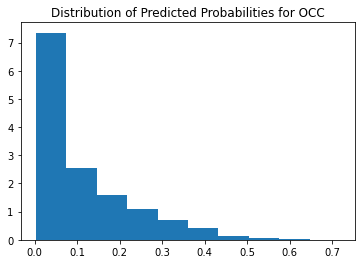

In [93]:
# plot distribution of predicted probabilities
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Distribution of Predicted Probabilities for OCC')
plt.hist(occ_prob, density=True)
plt.show()

In [136]:
# create dataframe and examine predicted probabilities for cases that the model gets correct
pred_df = pd.DataFrame(data=[np.array([int(x) for x in occ_true]), occ_predict, occ_prob]).T
pred_df.columns = ['OCC','rf_occ','rf_prob']
pred_df.sample(n=50).head()

,OCC,rf_occ,rf_prob
50720,4255.0,4255.0,0.040234
92576,8720.0,9620.0,0.002671
80627,7320.0,7320.0,0.226871
68250,6020.0,6020.0,0.199684
4416,300.0,300.0,0.201486


In [137]:
# summarise predicted probabilities for cases where the model predicts correctly
pred_df[pred_df.OCC==pred_df.rf_occ]['rf_prob'].describe()

count    79246.000000
mean         0.132567
std          0.120516
min          0.002417
25%          0.036229
50%          0.094061
75%          0.201015
max          0.718849
Name: rf_prob, dtype: float64

In [138]:
# summarise predicted probabilities for cases where model predicts incorrectly
pred_df[pred_df.OCC!=pred_df.rf_occ]['rf_prob'].describe()

count    23016.000000
mean         0.034140
std          0.051966
min          0.002389
25%          0.003258
50%          0.012208
75%          0.040386
max          0.511093
Name: rf_prob, dtype: float64

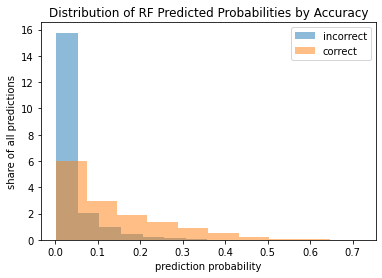

In [141]:
plt.hist(pred_df[pred_df.OCC!=pred_df.rf_occ]['rf_prob'], label = 'incorrect', density=True, alpha=0.5)
plt.hist(pred_df[pred_df.OCC==pred_df.rf_occ]['rf_prob'], label = 'correct', density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.title('Distribution of RF Predicted Probabilities by Accuracy')
plt.xlabel('prediction probability')
plt.ylabel('share of all predictions')
plt.show()

The above results show that relying on conventional probability thresholds for occupation predictions ($Pr=0.88$) would be overly strict for this model. The average predicted probability for cases where occupation codes are predicted correctly is $Pr=0.13$ compared to average predicted probability of $Pr=0.03$ for cases that were matched incorrectly. 

The plot above shows the distribution of predicted probabilities by prediction accuracy. Although predicted probabilities are low for most cases, those predicted correctly occupy the bulk of predicted probabilities in excess of $Pr=0.2$. Thus, these methods may be useful for prediction with a change in threshold predicted probability for accepting on a match.

Also note that many cases predicted accurately have predicted probabilities less than 0.2. Another option for selection would be to accept occupation code predictions based on the relationship of the maximum predicted probability to the probability distribution within a write-in. For example, each write-in has a predicted probability that it could belong to any one of the 570 occupation classes modeled here. Instead of choosing a one-size-fits-all threshold, we could instead select code assignments where the predicted probability lies sufficiently far away from the mean of other predictions. 

The function `probsigma(prob_dist, dev_dist)` returns a 1 or 0 depending on whether the max value of a probability distribution `prob_dist` is greater than `dev_dist` standard deviations from its mean. Exploration of different values indicated that predicted probabilities were more likely to lie within three or *more* standard deviations from the mean of a set of predictions than they are to be greater than some fixed threshold. Below I show the incidence of predictions where the maximum probability of a prediction is within six standard deviations ("six sigma") from the mean set of predictions and the set of records for which the maximum predicted probability is greater than or equal to 0.17.

In [100]:
# insted of selection probability cutoff, let's identify predicted probabilities within x sigma of mean
# instead of threshold, determine if max is greater than x*sigma from the mean of a prob distribution
def probsigma(prob_dist, dev_dist):
    if max(prob_dist) > np.std(prob_dist) * dev_dist + np.mean(prob_dist):
        return 1
    else:
        return 0

The above results demonstrate that we could retain a higher fraction of predictions choosing a flexible probability cutoff within each prediction versus a one-size-fits-all cutoff. About 25 percent of predictions from the random forest model would be retained using a probability cutoff of 0.17 compared to about 92 percent by selecting cases where the maximum probability is greater than six standard deviations from the mean. Of course, based on the graphic above, it is possible that those with predicted probabilities greater than 0.17 would almost universally be "accurate" predictions. Next, we compare the accuracy of predictions for these two cutoff values.

In [85]:
# prediction accuracy for max(Pr(x))>=0.17 cutoff
float(len(pred_df[(pred_df.rf_prob>=0.17) & (pred_df.OCC==pred_df.rf_occ)]) /
      len(pred_df[pred_df.rf_prob>=0.17]))

0.9687733218115401

In [87]:
# prediction accuracy for max(Pr(x))> 6 * sigma cutoff
float(len(pred_df[(pred_df.rf_prob_6sigma==1) & (pred_df.OCC==pred_df.rf_occ)]) /
      len(pred_df[pred_df.rf_prob_6sigma==1]))

0.8324013471436742

### Choosing a Cutoff Probability
The above results show that choosing cutoff maximum probability of 0.17 or greater results in accurate predictions for 97 percent of cases meeting this threshold. Those cases greater than six standard deviations from the mean are accurate 83 percent of the time.

This demonstrates that we face a tradeoff between selecting threshold levels, match accuracy, and the number of records we are able to retain from the predicted model. Below, we explore different combinations of fixed and flexible thresholds to evaluate this tradeoff more closely.

#### Fixed Threshold Values

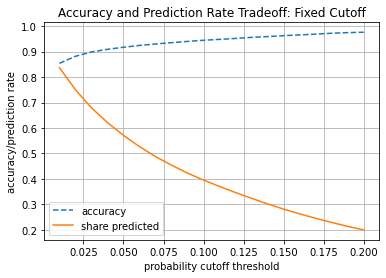

In [142]:
# fixed threshold values
fixed_thresholds = [x/100 for x in range(1,21)]
fixed_accuracy = []
fixed_obsshare = []

for i in fixed_thresholds:
    fixed_accuracy.append(float(len(pred_df[(pred_df.rf_prob>=i) & (pred_df.OCC==pred_df.rf_occ)]) /
                                len(pred_df[pred_df.rf_prob>=i])))
    fixed_obsshare.append(float(len(pred_df[pred_df.rf_prob>=i])/len(pred_df)))

# create dataframe
fixed_thresh_df = pd.DataFrame([fixed_thresholds, fixed_accuracy, fixed_obsshare]).T
fixed_thresh_df.columns = ['threshold','accuracy','obs_share']

# plot accuracy and observations share by threshold
plt.plot(fixed_thresh_df.threshold, fixed_thresh_df.accuracy, '--', label = 'accuracy')
plt.plot(fixed_thresh_df.threshold, fixed_thresh_df.obs_share, label='share predicted')
plt.grid(True)
plt.xlabel('probability cutoff threshold')
plt.ylabel('accuracy/prediction rate')
plt.title('Accuracy and Prediction Rate Tradeoff: Fixed Cutoff')
plt.legend()
plt.show()

The figure above shows the relationship between fixed threshold cutoff value and prediction accuracy (dashed line) and the share of observations that would be matched and not sent to clerical coding (solid line). The figure depicts probability threshold ranges between 0.01 and 0.20. Accuracy rates increase steadily with prediction probability, going from about 0.85 at 0.01 probability cutoff and exceeding 95 percent accuracy at a cutoff threshold of 0.02. 

However, the share of cases that would receive an autocode assignment falls much faster with increases in the threshold than is gained in prediction accuracy. A decision would have to be made in terms of the relative tradeoff between the cost savings from sending fewer cases to clerical coding versus prediction accuracy. One guide is that the production autocoder does not send cases to clerical coding if the predicted probability is 0.88. The figure above indicates that specifying a maximum probability threshold of 0.025 would be associated with a 90 percent accuracy rate and would save about 70 percent (of the 72 percent that were not matched via the index autocoder) of cases from going to clerical coding. Currently, the production autocoder sends between 50 and 60 percent of cases to clerical coding. An alternative would be to target the same number of cases going to clerical coding, which would be associated with a probability threshold between 0.05 and 0.075. While accuracy rates are in excess of 90 percent in this cutoff range, the gain in accuracy may not meet the cost savings in clerical coding by choosing a lower threshold.

#### Flexible Cutoffs

In [143]:
# examine a range of cutoffs at x standard deviations from the mean
sigma_list = [x for x in range(3,21)]

# execute probsigma function for each
sigma_out = []
sigma_obs = []
sigma_cols = ['rf_prob_{}sig'.format(x) for x in sigma_list]

for i in sigma_list:
    occ_probs_sigma = [probsigma(x, i) for x in occ_pred_probs]
    sigma_out.append( occ_probs_sigma )
    sigma_obs.append( float(sum(occ_probs_sigma)/len(occ_probs_sigma)) )

del i , occ_probs_sigma

In [144]:
# create dataframe to get accuracy scores
occ_sig_df = pd.DataFrame(data=[np.array([int(x) for x in occ_true]), occ_predict] + sigma_out).T
occ_sig_df.columns = ['OCC', 'rf_occ'] + sigma_cols

In [145]:
# get prediction accuracy at each threshold
sigma_accuracy = []

for i in sigma_list:
    sigvar = 'rf_prob_{}sig'.format(i)
    
    sigma_accuracy.append(float(len(occ_sig_df[(occ_sig_df[sigvar]==1) & (occ_sig_df.OCC==occ_sig_df.rf_occ)]) /
                                len(occ_sig_df[occ_sig_df[sigvar]==1])))

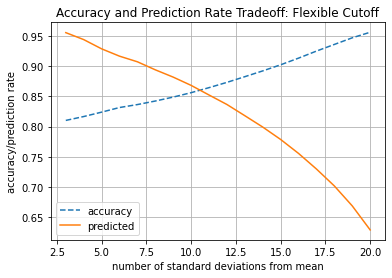

In [146]:
# create dataframe
sigma_thresh_df = pd.DataFrame([sigma_list, sigma_accuracy, sigma_obs]).T
sigma_thresh_df.columns = ['x_sigma','accuracy','obs_share']

# plot accuracy and observations share by threshold
plt.plot(sigma_thresh_df.x_sigma, sigma_thresh_df.accuracy, '--', label='accuracy')
plt.plot(sigma_thresh_df.x_sigma, sigma_thresh_df.obs_share, label='predicted')
plt.grid(True)
plt.legend()
plt.title('Accuracy and Prediction Rate Tradeoff: Flexible Cutoff')
plt.xlabel('number of standard deviations from mean')
plt.ylabel('accuracy/prediction rate')
plt.show()

The figure above shows the relationship between overall prediction accuracy and sample loss when choosing occupation codes based on a maximum probability estimate within different deviations from the mean. The tails of the probability distribution are long, with records for about 65 percent of cases being selected based on a probability estimate 20 standard deviations from the mean probability estimate. If we follow convention in the previous section and choose a 90 percent accuracy rate, that is associated with a maximum probability estimate being 15 standard deviations from the mean and assignment for between 75 and 80 percent of all cases predicted.

Compared to choosing a fixed cutoff, the flexible cutoff thresholds allow for greater sample retention for a given prediction accuracy; that is, fewer records go to clerical coding for a given probability threshold. For example, to achieve a 95 percent accuracy rate in the predicted sample, we could select cases where the prediction probability is 20 standard deviations from the mean. This creterion would assign codes for 60 percent of cases (net of what was assigned by the index autocoder) and leave close to 40 percent of the remainder to be clerical coded. For the fixed threshold model, achieving 95 percent occupation assignment accuracy requires specifying a probability threshold between 0.12 and 0.125 but at a cost of assigning codes for between 30 and 40 percent of cases (leaving 60 to 70 percent of cases for clerical coding).

In what follows, we create a selection criterion based on two cases: a fixed threshold of $Pr\ge0.03$ and a flexible threshold where the predicted probability is 15 or more standard deviations from the mean. I then add these predictions to the full file and summarise the incidence of occupation code assignment and the accuracy rate for this ensemble.

In [148]:
# select fixed threshold for max(Pr(x))>= 0.03
pred_df['rf_occ_fixed'] = np.where(pred_df.rf_prob >= 0.03 , pred_df.rf_occ, np.nan )
pred_df.drop(columns=['rf_occ'], inplace=True, axis=1)
pred_df.head()

,OCC,rf_prob,rf_occ_fixed
0,10.0,0.171665,10.0
1,10.0,0.008769,NaN
2,10.0,0.035612,10.0
3,10.0,0.122793,10.0
4,10.0,0.120382,10.0


In [149]:
pred_df.shape

(102262, 3)

In [150]:
# select flexible threshold for max(Pr(x)) >= 15 standard deviations from the mean
occ_sig_df['rf_occ_15sig'] = np.where(occ_sig_df.rf_prob_15sig == 1, occ_sig_df.rf_occ, np.nan)
occ_sig_df[['OCC','rf_occ_15sig']].head()

,OCC,rf_occ_15sig
0,10,10.0
1,10,10.0
2,10,10.0
3,10,10.0
4,10,10.0


## 3. Match Rates and Accuracy from the Ensemble
In this section I summarise the overall match rate and match accuracy from the two-part ensemble that matches on the index autocoder and then makes predictions from a trained random forest classifier. Since we only care about prediction accuracy, I simply work with the labeled occupation codes and the predictions from various sources.

### Occupation Matches from All Sources

In [151]:
# create combined set of rf predictions
rf_occs = pd.concat([pred_df, occ_sig_df['rf_occ_15sig']], axis=1)
print('shape of random forest prediction set:' , rf_occs.shape)
rf_occs.head()

shape of random forest prediction set: (102262, 4)


,OCC,rf_prob,rf_occ_fixed,rf_occ_15sig
0,10.0,0.171665,10.0,10.0
1,10.0,0.008769,NaN,10.0
2,10.0,0.035612,10.0,10.0
3,10.0,0.122793,10.0,10.0
4,10.0,0.120382,10.0,10.0


In [152]:
# full set of occupation codes
# NOTE: vertically stack index autocode with random forest
autocode_occs = pd.concat([acs_auto_index[['OCC','indexautoocc','indexautomcode']], rf_occs],
                          axis=0).reset_index(drop=True)

autocode_occs.head()

,OCC,indexautoocc,indexautomcode,rf_prob,rf_occ_fixed,rf_occ_15sig
0,0010,0010,101.0,NaN,NaN,NaN
1,0010,4710,211.0,NaN,NaN,NaN
2,0010,0010,101.0,NaN,NaN,NaN
3,0010,0010,101.0,NaN,NaN,NaN
4,0010,0010,101.0,NaN,NaN,NaN


In [153]:
# save file for later use
autocode_occs.to_csv('acs_n250_ensemble_autocode.csv', index=False)

In [26]:
autocode_occs = pd.read_csv('acs_n250_ensemble_autocode.csv')

In [27]:
autocode_occs.sample(n=100).head(10)

,OCC,indexautoocc,indexautomcode,rf_prob,rf_occ_fixed,rf_occ_15sig
4454,1350.0,5040.0,101.0,NaN,NaN,NaN
93956,4700.0,NaN,NaN,0.026058,NaN,4700.0
106428,5860.0,NaN,NaN,0.015686,NaN,5860.0
52050,960.0,NaN,NaN,0.036807,960.0,960.0
7782,2004.0,2004.0,101.0,NaN,NaN,NaN
41028,101.0,NaN,NaN,0.068591,5110.0,5110.0
63643,1935.0,NaN,NaN,0.082546,1935.0,1935.0
21708,4010.0,4010.0,111.0,NaN,NaN,NaN
86956,3960.0,NaN,NaN,0.333508,3960.0,3960.0
124131,7720.0,NaN,NaN,0.011103,NaN,NaN


In [165]:
# create single composite autocoded occupation code assignment
autocode_occs['autoocc1'] = np.where(autocode_occs.indexautoocc.isna(),
                                     autocode_occs.rf_occ_fixed,
                                     autocode_occs.indexautoocc)

autocode_occs['autoocc2'] = np.where(autocode_occs.indexautoocc.isna(),
                                     autocode_occs.rf_occ_15sig,
                                     autocode_occs.indexautoocc)

In [166]:
# add match code
autocode_occs['automc1'] = np.where(autocode_occs.indexautoocc.isna(),
                                    np.where(autocode_occs.rf_occ_fixed.isna(),
                                             autocode_occs.rf_occ_fixed,
                                             999),
                                    autocode_occs.indexautomcode)

autocode_occs['automc2'] = np.where(autocode_occs.indexautoocc.isna(),
                                    np.where(autocode_occs.rf_occ_15sig.isna(),
                                             autocode_occs.rf_occ_15sig,
                                             999),
                                    autocode_occs.indexautomcode)

In [167]:
autocode_occs.sample(n=100).head(10)

,OCC,indexautoocc,indexautomcode,rf_prob,rf_occ_fixed,rf_occ_15sig,autoocc1,autoocc2,automc1,automc2
57992,1410.0,NaN,NaN,0.298358,1410.0,1410.0,1410,1410,999.0,999.0
47256,440.0,NaN,NaN,0.022588,NaN,NaN,NaN,NaN,NaN,NaN
70158,2330.0,NaN,NaN,0.327449,2330.0,2330.0,2330,2330,999.0,999.0
118409,7110.0,NaN,NaN,0.056311,7110.0,7110.0,7110,7110,999.0,999.0
15441,3250.0,3250,111.0,NaN,NaN,NaN,3250,3250,111.0,111.0
10049,2632.0,2632,101.0,NaN,NaN,NaN,2632,2632,101.0,101.0
114175,6720.0,NaN,NaN,0.019020,NaN,6720.0,NaN,6720,NaN,999.0
99003,5140.0,NaN,NaN,0.259336,5140.0,5140.0,5140,5140,999.0,999.0
76955,2920.0,NaN,NaN,0.055172,2920.0,2920.0,2920,2920,999.0,999.0
75005,2810.0,NaN,NaN,0.215147,2810.0,2810.0,2810,2810,999.0,999.0


In [168]:
# convert occ field to float
autocode_occs.OCC = autocode_occs.OCC.apply(lambda x: float(x))
autocode_occs.autoocc1 = autocode_occs.autoocc1.apply(lambda x: float(x))
autocode_occs.autoocc2 = autocode_occs.autoocc2.apply(lambda x: float(x))

#### Match Rate and Accuracy of Ensemble with Fixed Cutoff Threshold
Below shows the match rate and accuracy rate of the ensemble autocoder for the sample of occupation write-in data. We use a fixed cutoff of an occupation autocode being chosen with a predicted probability greater than or equal to 0.03.



In [169]:
print('autocoder assignment rate:' , 
      '{:.1%}'.format(float(autocode_occs.autoocc1.notnull().sum()/len(autocode_occs))))
print('autocoder accuracy       :' ,
      '{:.1%}'.format(accuracy_score(autocode_occs[autocode_occs.autoocc1.notnull()]['OCC'],
                                     autocode_occs[autocode_occs.autoocc1.notnull()]['autoocc1'])))

autocoder assignment rate: 77.0%
autocoder accuracy       : 84.8%


#### Match Rate and Accuracy of Ensemble with Flexible Cutoff Threshold


In [170]:
print('autocoder assignment rate:' , 
      '{:.1%}'.format(float(autocode_occs.autoocc2.notnull().sum()/len(autocode_occs))))
print('autocoder accuracy       :' ,
      '{:.1%}'.format(accuracy_score(autocode_occs[autocode_occs.autoocc2.notnull()]['OCC'],
                                     autocode_occs[autocode_occs.autoocc2.notnull()]['autoocc2'])))

autocoder assignment rate: 84.1%
autocoder accuracy       : 85.5%


#### Tabulate Match Source for `autoocc2`
Discussions with IOSB indicated that the production autocoder does not record the stage at which an occupation code prediction is made. I built that into the two-step ensemble autocoder presented in this workbook. The following shows the distibution of occupation code assignments by source for those with code assignments meeting the flexible cutoff criterion of having a predicted probably 15 or more standard deviations from the mean for each prediction.

In [195]:
mc_summary = autocode_occs[autocode_occs.autoocc2.notnull()].groupby(['automc2']).count().reset_index()

In [196]:
mc_summary = mc_summary[['automc2','OCC']].copy()
mc_summary

,automc2,OCC
0,101.0,22638
1,111.0,14597
2,211.0,2926
3,301.0,53
4,311.0,24
5,999.0,79624


In [197]:
# export match code summary for presentation
mc_summary.to_csv('autocc2_mc_summary.csv', index=False)

In [201]:
# export overall match results
pred_df.to_csv('occ_pred_df.csv', index=False)
occ_sig_df.to_csv('occ_sig_df.csv', index=False)

## 4. Summary and Discussion

This jupyter notebook presented a complete ML workflow to implement an ensemble autocoder for assigning Census occupation codes to ACS occupation write-in text fields. The ensemble uses a custom exact-matching autocoder to first select a set of high-accuracy (approaching 100 percent) matches before using a trained random forest classifier model to predict occupation codes for the unmatched remainder. Compared to the production autocoder, which saves between 40 and 50 percent of records from going to clerical coding, the ensemble presented here is able to save close to 86 percent of records from going to clerical coding at the same level of model accuracy. The approach implemented here demonstrates that updating the occupation autocoder would generate real cost savings for the Census Bureau.

I used natural language processing (NLP) techniques to vectorize and lemmatize text from the write-in fields for use in a ML framework. Lemmatization was chosen as a way to reduce the column dimension of the text fields. In addition, I incorporated a relatively large set of features thought to account for differences in occupational assignment based on results from the urban and labor economics literatures.

The results of this work suffer from two major limitations. First, time and available Census computing resource limited my choice of model selection and the size of sample I could use to fit that model. I limited my sample to *n* = 250 for each of the 570 occupation classes (chosen randomly and with replacement), which amounted to a roughly 3 percent sample. The selected random forest model was chosen based on a Grid Search across combinations of three different hyperparameters. This modeling strategy required days of continuous server operation; other methods, such as Gradient Boosting, never converged prior to the project's termination. With more time, I could have attempted other modeling frameworks that might more efficiently handle the full set of records (e.g., Logistic Regression).

Second, accuracy estimates are dependent on the quality of the labels and they may be measured with error. The occupation code labels used here were previously assigned either by the existing production autocoder or clerical coder. To the extent that either is measured inaccurately, the accuracy estimates may be biased. Since the ML framework can only learn from the labeled data, this issue is likely to be more pronounced in the exact-match autocoder. Nonetheless, the labels are likely as good as they are going to get and, in the aggregate, are likely "correct" on average. 

This section is incomplete.